In [ ]:
import random
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'2.0.0'

In [3]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 5

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 10000

# percentage of words that will be used for validation
percentage_split = 0.60

# number of epochs for fitting the model training step
nb_epochs = 200

In [4]:
# total number of combinations
nb_letters**nb_chars

11881376

In [5]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [6]:
def build_model(nb_chars, nb_letters):

    # This returns a tensor
    inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')
    #original_inputs = tf.keras.Input(shape=(original_dim,), name='encoder_input')

    # a layer instance is callable on a tensor, and returns a tensor
    x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
    #x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
    #x = layers.Dense(64, activation='relu', name='hl_2')(x)

    outputs = []
    losses = {}
    for o in range(nb_chars):
        name_i = 'output_'+str(o)
        output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
        outputs.append(output_i)
        losses[name_i] = 'categorical_crossentropy'

    model = models.Model(inputs=inputs, outputs=outputs)

    rmsprop = tf.keras.optimizers.RMSprop(lr=0.01)

    model.compile(optimizer=rmsprop,
                         loss=losses,
                         metrics=['accuracy'])       
    return model

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs_(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [9]:
def print_readable_outputs(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    c_i = 0
    for char in outputs:
        s_i = 0
        for sample in char:
            best_letter = np.argmax(sample)
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [10]:
x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')

first_n_samples = 4

print_readable_inputs(x[:first_n_samples])
print('x (partial):\n', x[:first_n_samples], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
#scaler = MinMaxScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:first_n_samples], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y (readable):\n', y)
print()

# process the y data as useful ANN output data
y_train0 = keras.utils.to_categorical(y, nb_letters)
print('y (less readable):\n', y_train0[:first_n_samples], 'out of ',len(y_train0))
print('')

# process the y data as useful ANN multiple-outputs data
y_train = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_train = y_train0[:,c,:]
    y_train.append(yi_train)

# Not really displayable, henced commented
#print('y_train):')
#print(y_train[:first_n_samples])

x: (as readable inputs)
['aczcl', 'rznos', 'zpcfr', 'ltwkl']
x (partial):
 [[ 97  99 122  99 108]
 [114 122 110 111 115]
 [122 112  99 102 114]
 [108 116 119 107 108]] out of  10000

x_train:
 [[-1.67591811 -1.40066029  1.66497155 -1.38082529 -0.18851213]
 [ 0.5959696   1.69835433  0.06856563  0.20861389  0.74696563]
 [ 1.66509323  0.35095667 -1.39480646 -0.98346549  0.61332595]
 [-0.20587312  0.88991573  1.26587007 -0.32119917 -0.18851213]] out of  10000

y (readable):
 [[ 0  2 25  2 11]
 [17 25 13 14 18]
 [25 15  2  5 17]
 ...
 [25 13 22 19 10]
 [18 14 11 22 20]
 [ 3  6  1  5 17]]

y (less readable):
 [[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0

In [11]:
coding_model = build_model(nb_chars, nb_letters)
print(coding_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         24576       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
______________________________________________________________________________________________

In [12]:
history = coding_model.fit(x_train, y_train, validation_split=percentage_split, batch_size=32, epochs=nb_epochs, verbose=1)

Train on 4000 samples, validate on 6000 samples
Epoch 1/200
4000/4000 [==============================] - 3s 795us/sample - loss: 12.4259 - output_0_loss: 2.4962 - output_1_loss: 2.5010 - output_2_loss: 2.4917 - output_3_loss: 2.4624 - output_4_loss: 2.4746 - output_0_accuracy: 0.1670 - output_1_accuracy: 0.1657 - output_2_accuracy: 0.1610 - output_3_accuracy: 0.1782 - output_4_accuracy: 0.1737 - val_loss: 10.5854 - val_output_0_loss: 2.1498 - val_output_1_loss: 2.1396 - val_output_2_loss: 2.0700 - val_output_3_loss: 2.1019 - val_output_4_loss: 2.1258 - val_output_0_accuracy: 0.2168 - val_output_1_accuracy: 0.2273 - val_output_2_accuracy: 0.2450 - val_output_3_accuracy: 0.2208 - val_output_4_accuracy: 0.2243
Epoch 2/200
4000/4000 [==============================] - 1s 324us/sample - loss: 9.1913 - output_0_loss: 1.8639 - output_1_loss: 1.8375 - output_2_loss: 1.8418 - output_3_loss: 1.8165 - output_4_loss: 1.8316 - output_0_accuracy: 0.2957 - output_1_accuracy: 0.2957 - output_2_accuracy

4000/4000 [==============================] - 2s 415us/sample - loss: 3.6664 - output_0_loss: 0.7432 - output_1_loss: 0.7248 - output_2_loss: 0.7285 - output_3_loss: 0.7314 - output_4_loss: 0.7385 - output_0_accuracy: 0.6988 - output_1_accuracy: 0.7157 - output_2_accuracy: 0.7125 - output_3_accuracy: 0.7057 - output_4_accuracy: 0.7063 - val_loss: 3.8964 - val_output_0_loss: 0.7415 - val_output_1_loss: 0.7711 - val_output_2_loss: 0.7299 - val_output_3_loss: 0.8783 - val_output_4_loss: 0.7766 - val_output_0_accuracy: 0.7043 - val_output_1_accuracy: 0.6865 - val_output_2_accuracy: 0.7162 - val_output_3_accuracy: 0.6305 - val_output_4_accuracy: 0.6937
Epoch 14/200
4000/4000 [==============================] - 2s 423us/sample - loss: 3.4509 - output_0_loss: 0.7011 - output_1_loss: 0.6761 - output_2_loss: 0.6881 - output_3_loss: 0.6864 - output_4_loss: 0.6993 - output_0_accuracy: 0.7235 - output_1_accuracy: 0.7390 - output_2_accuracy: 0.7225 - output_3_accuracy: 0.7318 - output_4_accuracy: 0.7

4000/4000 [==============================] - 1s 291us/sample - loss: 1.8553 - output_0_loss: 0.3649 - output_1_loss: 0.3666 - output_2_loss: 0.3601 - output_3_loss: 0.3851 - output_4_loss: 0.3785 - output_0_accuracy: 0.8700 - output_1_accuracy: 0.8700 - output_2_accuracy: 0.8723 - output_3_accuracy: 0.8605 - output_4_accuracy: 0.8608 - val_loss: 2.1822 - val_output_0_loss: 0.4864 - val_output_1_loss: 0.3797 - val_output_2_loss: 0.4432 - val_output_3_loss: 0.4051 - val_output_4_loss: 0.4668 - val_output_0_accuracy: 0.8108 - val_output_1_accuracy: 0.8645 - val_output_2_accuracy: 0.8262 - val_output_3_accuracy: 0.8607 - val_output_4_accuracy: 0.8233
Epoch 26/200
4000/4000 [==============================] - 1s 316us/sample - loss: 1.7265 - output_0_loss: 0.3288 - output_1_loss: 0.3447 - output_2_loss: 0.3394 - output_3_loss: 0.3637 - output_4_loss: 0.3499 - output_0_accuracy: 0.8870 - output_1_accuracy: 0.8823 - output_2_accuracy: 0.8775 - output_3_accuracy: 0.8683 - output_4_accuracy: 0.8

4000/4000 [==============================] - 1s 361us/sample - loss: 1.0572 - output_0_loss: 0.2089 - output_1_loss: 0.2065 - output_2_loss: 0.2002 - output_3_loss: 0.2258 - output_4_loss: 0.2157 - output_0_accuracy: 0.9283 - output_1_accuracy: 0.9317 - output_2_accuracy: 0.9293 - output_3_accuracy: 0.9295 - output_4_accuracy: 0.9270 - val_loss: 1.1823 - val_output_0_loss: 0.2400 - val_output_1_loss: 0.2204 - val_output_2_loss: 0.2223 - val_output_3_loss: 0.3163 - val_output_4_loss: 0.1837 - val_output_0_accuracy: 0.9180 - val_output_1_accuracy: 0.9290 - val_output_2_accuracy: 0.9230 - val_output_3_accuracy: 0.8822 - val_output_4_accuracy: 0.9413
Epoch 38/200
4000/4000 [==============================] - 2s 526us/sample - loss: 0.9826 - output_0_loss: 0.1878 - output_1_loss: 0.2103 - output_2_loss: 0.1913 - output_3_loss: 0.1969 - output_4_loss: 0.1963 - output_0_accuracy: 0.9365 - output_1_accuracy: 0.9277 - output_2_accuracy: 0.9400 - output_3_accuracy: 0.9320 - output_4_accuracy: 0.9

4000/4000 [==============================] - 1s 305us/sample - loss: 0.6705 - output_0_loss: 0.1367 - output_1_loss: 0.1327 - output_2_loss: 0.1358 - output_3_loss: 0.1397 - output_4_loss: 0.1257 - output_0_accuracy: 0.9592 - output_1_accuracy: 0.9603 - output_2_accuracy: 0.9563 - output_3_accuracy: 0.9563 - output_4_accuracy: 0.9607 - val_loss: 0.7556 - val_output_0_loss: 0.1400 - val_output_1_loss: 0.1747 - val_output_2_loss: 0.0967 - val_output_3_loss: 0.2286 - val_output_4_loss: 0.1163 - val_output_0_accuracy: 0.9507 - val_output_1_accuracy: 0.9412 - val_output_2_accuracy: 0.9715 - val_output_3_accuracy: 0.9240 - val_output_4_accuracy: 0.9635
Epoch 50/200
4000/4000 [==============================] - 1s 307us/sample - loss: 0.6092 - output_0_loss: 0.1095 - output_1_loss: 0.1266 - output_2_loss: 0.1230 - output_3_loss: 0.1307 - output_4_loss: 0.1194 - output_0_accuracy: 0.9638 - output_1_accuracy: 0.9590 - output_2_accuracy: 0.9607 - output_3_accuracy: 0.9555 - output_4_accuracy: 0.9

4000/4000 [==============================] - 2s 393us/sample - loss: 0.5187 - output_0_loss: 0.0955 - output_1_loss: 0.1021 - output_2_loss: 0.1045 - output_3_loss: 0.1096 - output_4_loss: 0.1070 - output_0_accuracy: 0.9712 - output_1_accuracy: 0.9705 - output_2_accuracy: 0.9695 - output_3_accuracy: 0.9643 - output_4_accuracy: 0.9665 - val_loss: 0.7788 - val_output_0_loss: 0.1521 - val_output_1_loss: 0.1378 - val_output_2_loss: 0.2026 - val_output_3_loss: 0.1747 - val_output_4_loss: 0.1109 - val_output_0_accuracy: 0.9432 - val_output_1_accuracy: 0.9513 - val_output_2_accuracy: 0.9428 - val_output_3_accuracy: 0.9407 - val_output_4_accuracy: 0.9697
Epoch 62/200
4000/4000 [==============================] - 1s 301us/sample - loss: 0.4719 - output_0_loss: 0.0912 - output_1_loss: 0.0896 - output_2_loss: 0.0916 - output_3_loss: 0.1025 - output_4_loss: 0.0970 - output_0_accuracy: 0.9685 - output_1_accuracy: 0.9750 - output_2_accuracy: 0.9715 - output_3_accuracy: 0.9705 - output_4_accuracy: 0.9

4000/4000 [==============================] - 1s 288us/sample - loss: 0.3946 - output_0_loss: 0.0766 - output_1_loss: 0.0750 - output_2_loss: 0.0744 - output_3_loss: 0.0917 - output_4_loss: 0.0769 - output_0_accuracy: 0.9768 - output_1_accuracy: 0.9740 - output_2_accuracy: 0.9772 - output_3_accuracy: 0.9715 - output_4_accuracy: 0.9758 - val_loss: 0.6476 - val_output_0_loss: 0.1865 - val_output_1_loss: 0.0974 - val_output_2_loss: 0.1180 - val_output_3_loss: 0.1111 - val_output_4_loss: 0.1361 - val_output_0_accuracy: 0.9365 - val_output_1_accuracy: 0.9692 - val_output_2_accuracy: 0.9587 - val_output_3_accuracy: 0.9688 - val_output_4_accuracy: 0.9553
Epoch 74/200
4000/4000 [==============================] - 1s 287us/sample - loss: 0.3520 - output_0_loss: 0.0667 - output_1_loss: 0.0618 - output_2_loss: 0.0712 - output_3_loss: 0.0821 - output_4_loss: 0.0701 - output_0_accuracy: 0.9793 - output_1_accuracy: 0.9785 - output_2_accuracy: 0.9772 - output_3_accuracy: 0.9747 - output_4_accuracy: 0.9

4000/4000 [==============================] - 1s 325us/sample - loss: 0.3395 - output_0_loss: 0.0614 - output_1_loss: 0.0677 - output_2_loss: 0.0706 - output_3_loss: 0.0614 - output_4_loss: 0.0784 - output_0_accuracy: 0.9815 - output_1_accuracy: 0.9805 - output_2_accuracy: 0.9772 - output_3_accuracy: 0.9810 - output_4_accuracy: 0.9768 - val_loss: 0.4422 - val_output_0_loss: 0.0631 - val_output_1_loss: 0.1320 - val_output_2_loss: 0.0766 - val_output_3_loss: 0.0599 - val_output_4_loss: 0.1104 - val_output_0_accuracy: 0.9802 - val_output_1_accuracy: 0.9587 - val_output_2_accuracy: 0.9743 - val_output_3_accuracy: 0.9815 - val_output_4_accuracy: 0.9672
Epoch 86/200
4000/4000 [==============================] - 1s 326us/sample - loss: 0.3071 - output_0_loss: 0.0655 - output_1_loss: 0.0634 - output_2_loss: 0.0569 - output_3_loss: 0.0643 - output_4_loss: 0.0570 - output_0_accuracy: 0.9772 - output_1_accuracy: 0.9785 - output_2_accuracy: 0.9852 - output_3_accuracy: 0.9772 - output_4_accuracy: 0.9

4000/4000 [==============================] - 1s 370us/sample - loss: 0.2841 - output_0_loss: 0.0520 - output_1_loss: 0.0532 - output_2_loss: 0.0668 - output_3_loss: 0.0587 - output_4_loss: 0.0535 - output_0_accuracy: 0.9810 - output_1_accuracy: 0.9810 - output_2_accuracy: 0.9793 - output_3_accuracy: 0.9805 - output_4_accuracy: 0.9827 - val_loss: 0.4489 - val_output_0_loss: 0.1580 - val_output_1_loss: 0.0863 - val_output_2_loss: 0.0706 - val_output_3_loss: 0.0799 - val_output_4_loss: 0.0532 - val_output_0_accuracy: 0.9502 - val_output_1_accuracy: 0.9688 - val_output_2_accuracy: 0.9767 - val_output_3_accuracy: 0.9728 - val_output_4_accuracy: 0.9832
Epoch 98/200
4000/4000 [==============================] - 1s 352us/sample - loss: 0.2643 - output_0_loss: 0.0555 - output_1_loss: 0.0485 - output_2_loss: 0.0454 - output_3_loss: 0.0583 - output_4_loss: 0.0566 - output_0_accuracy: 0.9822 - output_1_accuracy: 0.9845 - output_2_accuracy: 0.9847 - output_3_accuracy: 0.9818 - output_4_accuracy: 0.9

4000/4000 [==============================] - 1s 355us/sample - loss: 0.2280 - output_0_loss: 0.0427 - output_1_loss: 0.0460 - output_2_loss: 0.0390 - output_3_loss: 0.0551 - output_4_loss: 0.0452 - output_0_accuracy: 0.9868 - output_1_accuracy: 0.9843 - output_2_accuracy: 0.9902 - output_3_accuracy: 0.9845 - output_4_accuracy: 0.9858 - val_loss: 0.5053 - val_output_0_loss: 0.1282 - val_output_1_loss: 0.1226 - val_output_2_loss: 0.0874 - val_output_3_loss: 0.0411 - val_output_4_loss: 0.1265 - val_output_0_accuracy: 0.9602 - val_output_1_accuracy: 0.9615 - val_output_2_accuracy: 0.9718 - val_output_3_accuracy: 0.9888 - val_output_4_accuracy: 0.9573
Epoch 110/200
4000/4000 [==============================] - 2s 423us/sample - loss: 0.2381 - output_0_loss: 0.0446 - output_1_loss: 0.0508 - output_2_loss: 0.0542 - output_3_loss: 0.0478 - output_4_loss: 0.0406 - output_0_accuracy: 0.9870 - output_1_accuracy: 0.9850 - output_2_accuracy: 0.9803 - output_3_accuracy: 0.9835 - output_4_accuracy: 0.

4000/4000 [==============================] - 1s 343us/sample - loss: 0.2431 - output_0_loss: 0.0610 - output_1_loss: 0.0443 - output_2_loss: 0.0463 - output_3_loss: 0.0488 - output_4_loss: 0.0426 - output_0_accuracy: 0.9795 - output_1_accuracy: 0.9883 - output_2_accuracy: 0.9865 - output_3_accuracy: 0.9865 - output_4_accuracy: 0.9872 - val_loss: 0.5025 - val_output_0_loss: 0.1104 - val_output_1_loss: 0.1263 - val_output_2_loss: 0.0972 - val_output_3_loss: 0.0568 - val_output_4_loss: 0.1113 - val_output_0_accuracy: 0.9657 - val_output_1_accuracy: 0.9557 - val_output_2_accuracy: 0.9648 - val_output_3_accuracy: 0.9823 - val_output_4_accuracy: 0.9622
Epoch 122/200
4000/4000 [==============================] - 2s 488us/sample - loss: 0.2317 - output_0_loss: 0.0450 - output_1_loss: 0.0479 - output_2_loss: 0.0460 - output_3_loss: 0.0430 - output_4_loss: 0.0498 - output_0_accuracy: 0.9847 - output_1_accuracy: 0.9845 - output_2_accuracy: 0.9870 - output_3_accuracy: 0.9872 - output_4_accuracy: 0.

4000/4000 [==============================] - 1s 287us/sample - loss: 0.1975 - output_0_loss: 0.0361 - output_1_loss: 0.0413 - output_2_loss: 0.0369 - output_3_loss: 0.0425 - output_4_loss: 0.0407 - output_0_accuracy: 0.9898 - output_1_accuracy: 0.9862 - output_2_accuracy: 0.9883 - output_3_accuracy: 0.9883 - output_4_accuracy: 0.9865 - val_loss: 0.3368 - val_output_0_loss: 0.1422 - val_output_1_loss: 0.0358 - val_output_2_loss: 0.0606 - val_output_3_loss: 0.0677 - val_output_4_loss: 0.0298 - val_output_0_accuracy: 0.9583 - val_output_1_accuracy: 0.9895 - val_output_2_accuracy: 0.9810 - val_output_3_accuracy: 0.9778 - val_output_4_accuracy: 0.9920
Epoch 134/200
4000/4000 [==============================] - 3s 644us/sample - loss: 0.1999 - output_0_loss: 0.0335 - output_1_loss: 0.0445 - output_2_loss: 0.0440 - output_3_loss: 0.0381 - output_4_loss: 0.0399 - output_0_accuracy: 0.9902 - output_1_accuracy: 0.9875 - output_2_accuracy: 0.9868 - output_3_accuracy: 0.9883 - output_4_accuracy: 0.

4000/4000 [==============================] - 1s 307us/sample - loss: 0.1807 - output_0_loss: 0.0351 - output_1_loss: 0.0307 - output_2_loss: 0.0413 - output_3_loss: 0.0339 - output_4_loss: 0.0398 - output_0_accuracy: 0.9885 - output_1_accuracy: 0.9912 - output_2_accuracy: 0.9883 - output_3_accuracy: 0.9883 - output_4_accuracy: 0.9880 - val_loss: 0.1888 - val_output_0_loss: 0.0296 - val_output_1_loss: 0.0733 - val_output_2_loss: 0.0288 - val_output_3_loss: 0.0283 - val_output_4_loss: 0.0288 - val_output_0_accuracy: 0.9908 - val_output_1_accuracy: 0.9743 - val_output_2_accuracy: 0.9917 - val_output_3_accuracy: 0.9902 - val_output_4_accuracy: 0.9910
Epoch 146/200
4000/4000 [==============================] - 1s 323us/sample - loss: 0.1924 - output_0_loss: 0.0449 - output_1_loss: 0.0395 - output_2_loss: 0.0342 - output_3_loss: 0.0457 - output_4_loss: 0.0281 - output_0_accuracy: 0.9850 - output_1_accuracy: 0.9862 - output_2_accuracy: 0.9902 - output_3_accuracy: 0.9887 - output_4_accuracy: 0.

4000/4000 [==============================] - 1s 322us/sample - loss: 0.1854 - output_0_loss: 0.0318 - output_1_loss: 0.0349 - output_2_loss: 0.0309 - output_3_loss: 0.0422 - output_4_loss: 0.0456 - output_0_accuracy: 0.9902 - output_1_accuracy: 0.9893 - output_2_accuracy: 0.9905 - output_3_accuracy: 0.9877 - output_4_accuracy: 0.9880 - val_loss: 0.1741 - val_output_0_loss: 0.0222 - val_output_1_loss: 0.0357 - val_output_2_loss: 0.0441 - val_output_3_loss: 0.0296 - val_output_4_loss: 0.0420 - val_output_0_accuracy: 0.9937 - val_output_1_accuracy: 0.9875 - val_output_2_accuracy: 0.9850 - val_output_3_accuracy: 0.9910 - val_output_4_accuracy: 0.9873
Epoch 158/200
4000/4000 [==============================] - 2s 417us/sample - loss: 0.1856 - output_0_loss: 0.0436 - output_1_loss: 0.0455 - output_2_loss: 0.0445 - output_3_loss: 0.0236 - output_4_loss: 0.0283 - output_0_accuracy: 0.9860 - output_1_accuracy: 0.9850 - output_2_accuracy: 0.9858 - output_3_accuracy: 0.9923 - output_4_accuracy: 0.

4000/4000 [==============================] - 2s 499us/sample - loss: 0.1981 - output_0_loss: 0.0411 - output_1_loss: 0.0333 - output_2_loss: 0.0513 - output_3_loss: 0.0421 - output_4_loss: 0.0304 - output_0_accuracy: 0.9875 - output_1_accuracy: 0.9898 - output_2_accuracy: 0.9862 - output_3_accuracy: 0.9865 - output_4_accuracy: 0.9910 - val_loss: 0.2923 - val_output_0_loss: 0.0549 - val_output_1_loss: 0.0342 - val_output_2_loss: 0.0680 - val_output_3_loss: 0.0751 - val_output_4_loss: 0.0600 - val_output_0_accuracy: 0.9842 - val_output_1_accuracy: 0.9903 - val_output_2_accuracy: 0.9853 - val_output_3_accuracy: 0.9773 - val_output_4_accuracy: 0.9817
Epoch 170/200
4000/4000 [==============================] - 2s 445us/sample - loss: 0.1488 - output_0_loss: 0.0328 - output_1_loss: 0.0241 - output_2_loss: 0.0255 - output_3_loss: 0.0353 - output_4_loss: 0.0312 - output_0_accuracy: 0.9902 - output_1_accuracy: 0.9927 - output_2_accuracy: 0.9927 - output_3_accuracy: 0.9890 - output_4_accuracy: 0.

4000/4000 [==============================] - 2s 615us/sample - loss: 0.1636 - output_0_loss: 0.0391 - output_1_loss: 0.0290 - output_2_loss: 0.0319 - output_3_loss: 0.0272 - output_4_loss: 0.0365 - output_0_accuracy: 0.9862 - output_1_accuracy: 0.9908 - output_2_accuracy: 0.9915 - output_3_accuracy: 0.9930 - output_4_accuracy: 0.9895 - val_loss: 0.3165 - val_output_0_loss: 0.0487 - val_output_1_loss: 0.0656 - val_output_2_loss: 0.0774 - val_output_3_loss: 0.0671 - val_output_4_loss: 0.0579 - val_output_0_accuracy: 0.9832 - val_output_1_accuracy: 0.9778 - val_output_2_accuracy: 0.9772 - val_output_3_accuracy: 0.9797 - val_output_4_accuracy: 0.9815
Epoch 182/200
4000/4000 [==============================] - 1s 330us/sample - loss: 0.1519 - output_0_loss: 0.0323 - output_1_loss: 0.0390 - output_2_loss: 0.0226 - output_3_loss: 0.0308 - output_4_loss: 0.0272 - output_0_accuracy: 0.9900 - output_1_accuracy: 0.9868 - output_2_accuracy: 0.9930 - output_3_accuracy: 0.9925 - output_4_accuracy: 0.

4000/4000 [==============================] - 1s 340us/sample - loss: 0.1546 - output_0_loss: 0.0294 - output_1_loss: 0.0313 - output_2_loss: 0.0311 - output_3_loss: 0.0284 - output_4_loss: 0.0343 - output_0_accuracy: 0.9908 - output_1_accuracy: 0.9902 - output_2_accuracy: 0.9912 - output_3_accuracy: 0.9912 - output_4_accuracy: 0.9905 - val_loss: 0.3091 - val_output_0_loss: 0.0401 - val_output_1_loss: 0.0497 - val_output_2_loss: 0.0544 - val_output_3_loss: 0.0608 - val_output_4_loss: 0.1040 - val_output_0_accuracy: 0.9877 - val_output_1_accuracy: 0.9852 - val_output_2_accuracy: 0.9823 - val_output_3_accuracy: 0.9825 - val_output_4_accuracy: 0.9643
Epoch 194/200
4000/4000 [==============================] - 1s 323us/sample - loss: 0.1272 - output_0_loss: 0.0232 - output_1_loss: 0.0192 - output_2_loss: 0.0231 - output_3_loss: 0.0305 - output_4_loss: 0.0311 - output_0_accuracy: 0.9940 - output_1_accuracy: 0.9940 - output_2_accuracy: 0.9923 - output_3_accuracy: 0.9898 - output_4_accuracy: 0.

In [13]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'output_0_loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss', 'output_0_accuracy', 'output_1_accuracy', 'output_2_accuracy', 'output_3_accuracy', 'output_4_accuracy', 'val_loss', 'val_output_0_loss', 'val_output_1_loss', 'val_output_2_loss', 'val_output_3_loss', 'val_output_4_loss', 'val_output_0_accuracy', 'val_output_1_accuracy', 'val_output_2_accuracy', 'val_output_3_accuracy', 'val_output_4_accuracy'])


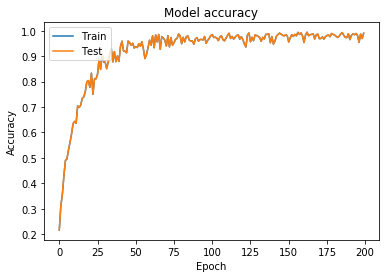

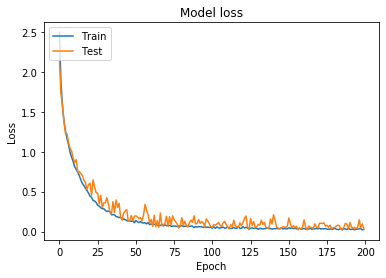

In [14]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['val_output_0_accuracy'])
plt.plot(history.history['val_output_0_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
nb_words_to_test = 100000

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
x_test_scaled  = scaler.transform(x_test)

y_test_raw = encrypt(x_test, nb_words_to_test, nb_chars)
y_test_raw_cate = keras.utils.to_categorical(y_test_raw, nb_letters)

# process the y data as useful ANN multiple-outputs data
y_test = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_test = y_test_raw_cate[:,c,:]
    y_test.append(yi_test)


print('\n# Evaluate on test data')
results = coding_model.evaluate(x_test_scaled, y_test, batch_size=128)
for r in range(len(results)):
    print(coding_model.metrics_names[r],':',results[r])


# Evaluate on test data


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss : 0.232115676817894
output_0_loss : 0.031012308
output_1_loss : 0.0938223
output_2_loss : 0.033841055
output_3_loss : 0.052941248
output_4_loss : 0.020443635
output_0_accuracy : 0.98962
output_1_accuracy : 0.97646
output_2_accuracy : 0.99047
output_3_accuracy : 0.98321
output_4_accuracy : 0.99341


In [16]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_scaled  = scaler.transform(x_test)
print("x_test_scaled=\n", x_test_scaled)
print('-->')

prediction = coding_model.predict(x_test_scaled)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test, nb_chars)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

['ylddr', 'tylva', 'ifuon']
x_test=
 [[121 108 100 100 114]
 [116 121 108 118  97]
 [105 102 117 111 110]]
x_test_scaled=
 [[ 1.53145278 -0.1880024  -1.26177263 -1.24837202  0.61332595]
 [ 0.86325051  1.56361456 -0.19750202  1.13578675 -1.65854862]
 [-0.60679448 -0.99644099  0.99980242  0.20861389  0.07876723]]
-->
prediction
['24 11 3 3 17', '19 24 11 21 0', '8 5 20 14 13']
check prediction
y_test=
 [[24 11  3  3 17]
 [19 24 11 21  0]
 [ 8  5 20 14 13]]
